In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import time
%matplotlib inline

### Extraer datos de la salida de WRF

In [2]:
file = 'wrfout_d01_2012-05-30_00:00:00.nc'

In [3]:
nc = Dataset(file, 'r')

In [4]:
for i in nc.variables:
    print(i, nc.variables[i].shape)

Times (97, 19)
XLAT (97, 29, 29)
XLONG (97, 29, 29)
LU_INDEX (97, 29, 29)
ZNU (97, 59)
ZNW (97, 60)
ZS (97, 4)
DZS (97, 4)
VAR_SSO (97, 29, 29)
U (97, 59, 29, 30)
V (97, 59, 30, 29)
W (97, 60, 29, 29)
PH (97, 60, 29, 29)
PHB (97, 60, 29, 29)
T (97, 59, 29, 29)
HFX_FORCE (97,)
LH_FORCE (97,)
TSK_FORCE (97,)
HFX_FORCE_TEND (97,)
LH_FORCE_TEND (97,)
TSK_FORCE_TEND (97,)
MU (97, 29, 29)
MUB (97, 29, 29)
NEST_POS (97, 29, 29)
P (97, 59, 29, 29)
PB (97, 59, 29, 29)
FNM (97, 59)
FNP (97, 59)
RDNW (97, 59)
RDN (97, 59)
DNW (97, 59)
DN (97, 59)
CFN (97,)
CFN1 (97,)
THIS_IS_AN_IDEAL_RUN (97,)
P_HYD (97, 59, 29, 29)
Q2 (97, 29, 29)
T2 (97, 29, 29)
TH2 (97, 29, 29)
PSFC (97, 29, 29)
U10 (97, 29, 29)
V10 (97, 29, 29)
RDX (97,)
RDY (97,)
RESM (97,)
ZETATOP (97,)
CF1 (97,)
CF2 (97,)
CF3 (97,)
ITIMESTEP (97,)
XTIME (97,)
QVAPOR (97, 59, 29, 29)
QCLOUD (97, 59, 29, 29)
QRAIN (97, 59, 29, 29)
QICE (97, 59, 29, 29)
QSNOW (97, 59, 29, 29)
QGRAUP (97, 59, 29, 29)
QHAIL (97, 59, 29, 29)
QNCLOUD (97, 59, 29,

In [5]:
for dim in nc.dimensions:
    print(dim, nc.dimensions[dim])

Time <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'Time', size = 97

DateStrLen <class 'netCDF4._netCDF4.Dimension'>: name = 'DateStrLen', size = 19

west_east <class 'netCDF4._netCDF4.Dimension'>: name = 'west_east', size = 29

south_north <class 'netCDF4._netCDF4.Dimension'>: name = 'south_north', size = 29

bottom_top <class 'netCDF4._netCDF4.Dimension'>: name = 'bottom_top', size = 59

bottom_top_stag <class 'netCDF4._netCDF4.Dimension'>: name = 'bottom_top_stag', size = 60

soil_layers_stag <class 'netCDF4._netCDF4.Dimension'>: name = 'soil_layers_stag', size = 4

west_east_stag <class 'netCDF4._netCDF4.Dimension'>: name = 'west_east_stag', size = 30

south_north_stag <class 'netCDF4._netCDF4.Dimension'>: name = 'south_north_stag', size = 30



## Extraigo variables que se van a usar

In [6]:
g = 9.8
T = nc.variables['T']
u = nc.variables['U']
v = nc.variables['V']
T2 = nc.variables['T2']
PH = nc.variables['PH']
PHB = nc.variables['PHB']

In [7]:
xlat = nc.variables['XLAT']
xlong = nc.variables['XLONG']

xlat_u = nc.variables['XLAT_U']
xlong_u = nc.variables['XLONG_U']

xlat_v = nc.variables['XLAT_V']
xlong_v = nc.variables['XLONG_V']


## Interpolación de velocidades

In [8]:
'''

    `XLON`, `XLAT`, ...  van con su dimensión temporal. 
    `U` no va con su dimensión temporal, sólo las dimensiones espaciales correspondientes a un tiempo.
    `ej: U[1, :, :, :]`

'''


def interpolate_velocity(XLONG, XLAT, XLONG_U, XLAT_U, U, u = True, Kind = 'linear'):
    
    x_old = XLONG_U[0, 1, :]
    y_old = XLAT_U[0, :, 1]
    x_new = XLONG[0, 1, :]
    y_new = XLAT[0, :, 1]
    
    if u == True:
        u_shape = (U.shape[0], U.shape[1], U.shape[2]-1)
    
    else:
        u_shape = (U.shape[0], U.shape[1] - 1, U.shape[2])
    
    
    U_out = np.zeros(u_shape, dtype='float32')
    #U_out = np.zeros(u_shape, dtype='float32')
    
    for h in range(0, U.shape[0]):
        
        f = interpolate.interp2d(x_old, y_old, U[h, :, :], kind = Kind)
        U_out[h, :, :] = f(x_new, y_new)

    return U_out

In [9]:
u_interpol = interpolate_velocity(xlong, xlat, xlong_u, xlat_u, u[0,:, :, :])

In [10]:
u_interpol.shape

(59, 29, 29)

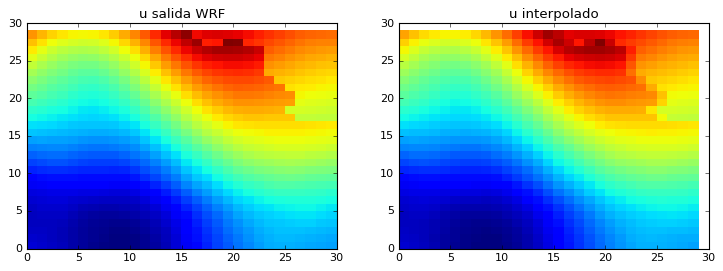

In [11]:
h = 57 # altura o número de capa

fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(221)
ax1.pcolor(u[0, h, :, :])
plt.title("u salida WRF")

ax2 = fig.add_subplot(222)
ax2.pcolor(u_interpol[h, :, :])
#ax2.title(title = 'u interpolado')
plt.title('u interpolado')

### Ahora para v

In [12]:
v_interpol = interpolate_velocity(xlong, xlat, xlong_v, xlat_v, v[0,:,:,:], u = False)

In [14]:
start = time.time()

interpolate_velocity(xlong, xlat, xlong_v, xlat_v, v[0,:,:,:], u = False)

end = time.time()
print(end - start, 'seg')

0.011115074157714844 seg


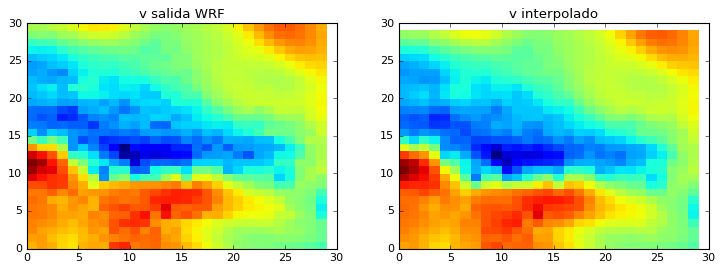

In [15]:
h = 0 # altura o número de capa

fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(221)
ax1.pcolor(v[0, h, :, :])
#Cs = plt.contour(relieve[1, :, :], colors= 'k')
#plt.clabel(Cs, fontsize = 8)
plt.title("v salida WRF")


ax2 = fig.add_subplot(222)
ax2.pcolor(v_interpol[h, :, :])
#Cs = plt.contour(relieve[1, :, :], colors= 'k')
#plt.clabel(Cs, fontsize = 8)
plt.title('v interpolado')

## Compute height

Según el [manual de usuario de WRF](http://mailman.ucar.edu/pipermail/wrf-users/2011/002437.html) muchas variables de salida del WRF se encuentran en medio de la rejilla vertical, es por eso que cuando se calcula la altura usando las variables `PH` y `PHB`, se obtiene un valor extra en la componente vertical que no tienen  las otras variables  como las velocidades `U` y `V`. Esto se debe a que algunas variables se encuentran en medio de la malla vertical.

Lo que sugieren en el manual de usuario es promediar la altura de la capa de arriba con la altura de la capa de abajo, para abotener la altura en medio de la malla vertical, es decir:

`z = ((PH(n)+PHB(n)) + (PH(n+1) + PHB(n+1))) / 9.8`



In [16]:
'''
    compute_height(PH, PHB)
    
    PH y PHB deben ser prporcionados como una matriz de tres dimensiones es decir hay especificar su variable temporal. 
    Por ejemplo: Para el tiempo t = 0, se debe introducir PH[0, :, :, :] y PHB[0, :, :, :].
'''

def compute_height(PH, PBH):
    
    g = 9.8
    z_shape = (PH.shape[0]-1, PH.shape[1], PH.shape[2])
    Z = np.zeros(z_shape, dtype='float32')
    
    
    for h in range(0, PH.shape[0]-1):
        
        Z[h, :, :] = ((PH[h, :, :] + PBH[h, :, :]) + (PH[h+1, :, :] + PBH[h+1, :, :]))/g
        
    return Z    

In [17]:
Z = compute_height(PH[0, :, :, :], PHB[0, :, :, :])

In [19]:
Z.shape

(59, 29, 29)

In [18]:
PH.shape

(97, 60, 29, 29)

In [20]:
u.shape

(97, 59, 29, 30)

In [55]:
z_range = range(0, len(Z[:, 20, 20]))

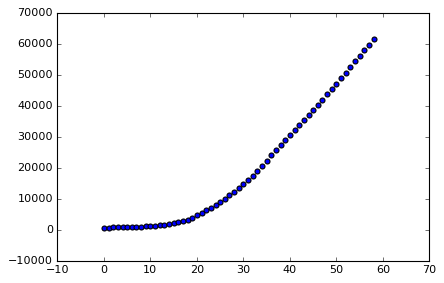

In [57]:
plt.scatter(z_range, Z[:, 20, 20])

In [53]:
Z[:, 20, 20]

array([   593.16021729,    638.22320557,    683.40740967,    728.70550537,
          774.10290527,    819.59289551,    865.16729736,    910.82226562,
          979.46984863,   1071.19885254,   1163.21960449,   1255.57019043,
         1394.8503418 ,   1581.58581543,   1769.71496582,   2055.12402344,
         2440.10229492,   2831.19335938,   3228.69799805,   3810.25585938,
         4584.93457031,   5387.90820312,   6222.61621094,   7092.8203125 ,
         8003.37060547,   8955.94335938,   9955.13574219,  11004.43652344,
        12110.58691406,  13285.0234375 ,  14534.16699219,  15870.21679688,
        17309.38671875,  18873.9375    ,  20535.08984375,  22225.7578125 ,
        23919.01367188,  25610.73046875,  27309.9296875 ,  28997.08398438,
        30640.28710938,  32241.12109375,  33814.24609375,  35376.29296875,
        36956.59765625,  38574.8125    ,  40231.30859375,  41927.5390625 ,
        43643.81640625,  45373.48828125,  47111.1015625 ,  48870.25390625,
        50648.27734375,  

## Número de Richardson

Se usa el algoritmo para calcular Richardson que viene en el artículo de [S. Joffre](https://link.springer.com/article/10.1023%2FA%3A1018956525605?LI=true):

$$Ri(z_{i+1}) = \frac{g}{T_s} \frac{(\theta_{i+2} - \theta_i)(z_{i+2} - z_i)}{(V_{i+2} - V_i)^2}.$$

Si se cambian los índices se tiene:

$$Ri(z_{i}) = \frac{g}{T_s} \frac{(\theta_{i+1} - \theta_{i-1})(z_{i+1} - z_{i-1})}{(V_{i+1} - V_{i-1})^2}.$$

No se tienen valores del número de Richardson en la capa más baja y en la capa superior.


In [22]:
def compute_Richardson(T_s, θ, Z, u, v):
    g = 9.8
    Ri = np.zeros(Z.shape, dtype='float32')
    
    for i in range(1,len(θ)-2):
        
        Vu = np.sqrt(u[i+1]**2 + v[i+1]**2)
        Vd = np.sqrt(u[i-1]**2 + v[i-1]**2)
        
        Ri[i] = g / T_s * ((θ[i+1] - θ[i-1])*(Z[i+1] - Z[i-1]))/(Vu - Vd)**2
    
    return Ri

In [63]:
nx = 20
ny = nx
t = 0
print('Latitud ', xlat[t, nx, ny])
print('Longitud', xlong[t, nx, ny])
print('tiempo', 0)
Ri = compute_Richardson(T2[t, nx, ny], T[t, :, nx, ny], Z[:, nx, ny], u_interpol[:, nx, ny], v_interpol[:, nx, ny])

Latitud  20.6172
Longitud -97.9258
tiempo 0


In [64]:
time = nc.dimensions['Time']

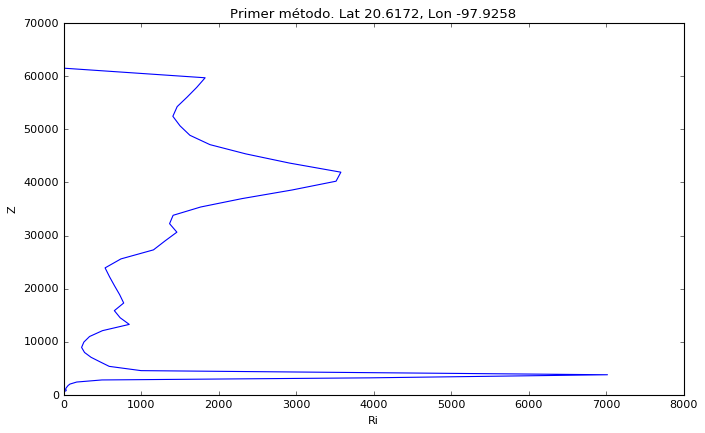

In [84]:
plt.figure(figsize=(10,6))
plt.plot(Ri, Z[:, nx, ny])
plt.xlabel("Ri")
plt.ylabel('Z')
plt.title('Primer método. Lat ' + str(xlat[t, nx, ny]) + ', Lon ' + str(xlong[t, nx, ny]))

**Observaciones:** Claramente algo está mal.

## Probando el segundo método

El segundo método viene en el artículo de [Xueliang Feng](http://www.mdpi.com/2073-4433/6/9/1346/htm), donde se calcula el número de Richardson de la siguiente forma:

$$Ri(z) = \frac{g \ (z -z_0)(\theta(z) - \theta_0)}{\theta(z)(u(z)^2) + v(z)^2)}$$

In [66]:
ny

20

In [70]:
Z[:, nx, ny][0]

593.16022

In [71]:
T[0,:, nx, ny][0]

6.6882935

In [74]:
T2[0, nx, ny]

304.69315

In [78]:
def compute_Richardson_2(θ, Z, u, v):
    g = 9.8
    Ri = np.zeros(Z.shape, dtype='float32')
    
    for i in range(0,len(θ)-1):
        
        Ri[i] = (g*(θ[i] - θ[0])*(Z[i] - Z[0]))/(θ[i] * (u[i]**2 + v[i]**2))
    
    return Ri

In [92]:
nx = 20
ny = nx
t = 10
print('Latitud ', xlat[t, nx, ny])
print('Longitud', xlong[t, nx, ny])
print('tiempo', 0)
Ri2 = compute_Richardson_2(T[t, :, nx, ny], Z[:, nx, ny], u_interpol[:, nx, ny], v_interpol[:, nx, ny])

Latitud  20.6172
Longitud -97.9258
tiempo 0


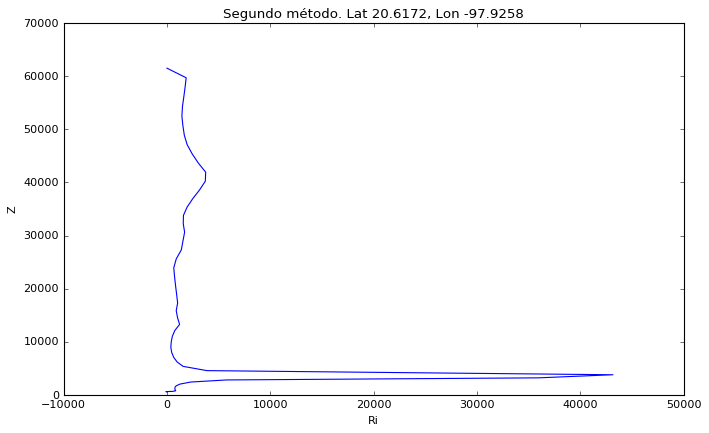

In [93]:
plt.figure(figsize=(10,6))
plt.plot(Ri2, Z[:, nx, ny])
plt.xlabel("Ri")
plt.ylabel('Z')
plt.title('Segundo método. Lat ' + str(xlat[t, nx, ny]) + ', Lon ' + str(xlong[t, nx, ny]))

In [94]:
relieve = nc.variables['HGT']

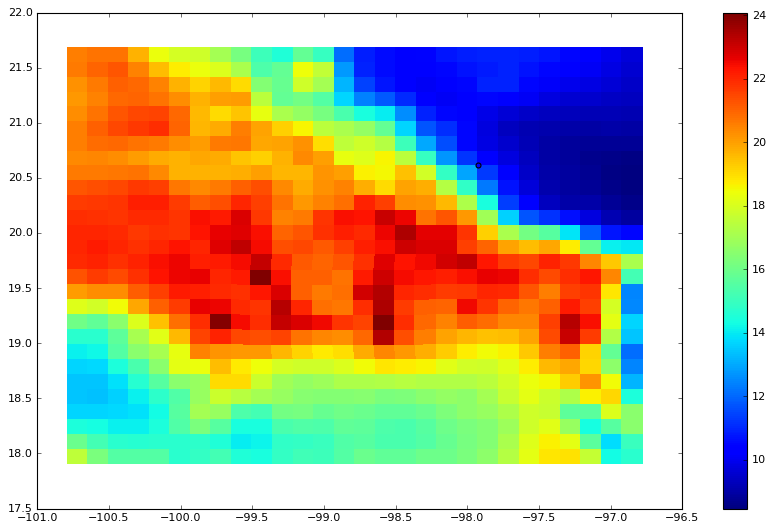

In [102]:
h = 20
fig = plt.figure(figsize=(13,8))
#Cs = plt.contour(relieve[1, :, :], colors= 'k')
#plt.clabel(Cs, fontsize = 8)
plt.pcolormesh(xlong[h, :, :], xlat[h, :, :], T[0,h, :, :])
plt.colorbar()
plt.scatter(xlong[h, nx, ny], xlat[h, nx, ny])